# Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate
from tensorflow.keras.models import Model

# Import data and visualize

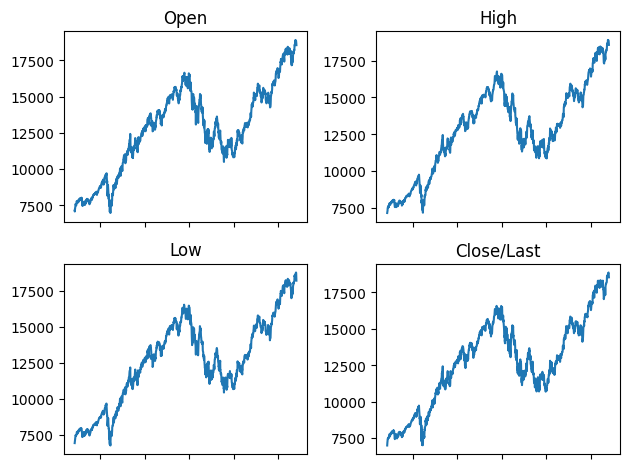

In [107]:
#df = pd.read_csv(r"dataset\NASDAQ100_1month.csv")
#df = pd.read_csv(r"dataset\NASDAQ100_6month.csv")
#df = pd.read_csv(r"dataset\NASDAQ100_1year.csv")
df = pd.read_csv(r"dataset\NASDAQ100_5years.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

figure, axis = plt.subplots(2, 2)

axis[0,0].plot(df['Date'], df['Open'])
axis[0,0].set_title("Open")
axis[0,0].set_xticklabels([])

axis[0,1].plot(df['Date'], df['High'])
axis[0,1].set_title("High")
axis[0,1].set_xticklabels([])

axis[1,0].plot(df['Date'], df['Low'])
axis[1,0].set_title("Low")
axis[1,0].set_xticklabels([])

axis[1,1].plot(df['Date'], df['Close/Last'])
axis[1,1].set_title("Close/Last")
axis[1,1].set_xticklabels([])

plt.tight_layout()
plt.show()

# Convert data to sequential and split to training and testing set

In [108]:
features = df[['Open', 'High','Low','Close/Last']].values

scaler = MinMaxScaler(feature_range=(0,1)) # scale the data between 0 and 1
scaled_features = scaler.fit_transform(features) # fit and transform the data
scaled_features.shape

(1259, 4)

In [109]:
def make_seq(data, seq_length):
  seq = []
  label = []
  for i in range(len(data) - seq_length):
    seq.append(data[i:i + seq_length])
    label.append(data[i + seq_length])
  
  return np.array(seq) , np.array(label)

seq_len = 5
X, y = make_seq(scaled_features, seq_len)

train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1003, 5, 4), (1003, 4), (251, 5, 4), (251, 4))

# Make attention layer class that inherits from tf.keras.layers.Layer

In [110]:
class attention_layer(tf.keras.layers.Layer):
  def __init__(self):
    """
    This class is the attention layer that will be used in the model
    It inherits from the tf.keras.layers.Layer class

    build(): This method is used to create the weights and biases that will be used in the layer
    call(): This method is used to calculate the attention scores and the context vector
    """
    super().__init__()
    self.attention_weights = None
    self.attention_bias = None
    self.context_vector = None

  def build(self, input_shape):
    """
    This method is used to create the weights and biases that will be used in the layer

    input_shape: This is the shape of the input data
    """
    self.attention_weights = self.add_weight(name="attention_weights", shape = (input_shape[-1], input_shape[-1]), initializer = "uniform", trainable = True)
    self.attention_bias = self.add_weight(name="attention_bias", shape = (input_shape[-1],), initializer = "uniform", trainable =True )
    self.context_vector = self.add_weight(name="attention_context", shape=(input_shape[-1],), initializer = "uniform", trainable = True)

  def call(self,inputs):
    """
    This method is used to calculate the attention scores and the context vector

    inputs: This is the input data
    """
    forward_transform = tf.tanh(tf.tensordot(inputs, self.attention_weights, axes=1) + self.attention_bias)
    attention_scores = tf.nn.softmax(tf.tensordot(forward_transform, self.context_vector, axes=1), axis=1)
    output = inputs * tf.expand_dims(attention_scores, -1)
    return tf.reduce_sum(output, axis=1)

# Define LSTM encoder-decoder model with attention

In [111]:
def LSTM_encoder_decoder(seq_length, feature_dimension):
  """
  This function is used to create the LSTM encoder-decoder model with attention

  Structure of the model:
  1. Encoder: LSTM layer with 64 units
  2. Attention: Attention layer
  3. Decoder: LSTM layer with 64 units and Dense layer

  Working:
  1. The input data is passed through the encoder LSTM layer
  2. The output of the encoder is passed through the attention layer to get the context vector
  3. The context vector is passed through the decoder LSTM layer and Dense layer to get the output

  Trainable parameters:
  1. Weights and biases of the LSTM layers
  2. Weights and biases of the Dense layer
  3. Weights and biases of the attention layer

  args:

  seq_length: This is the length of the sequence
  feature_dimension: This is the dimension of the features in the data

  return: This function returns the LSTM encoder-decoder model with attention
  """

  # Encoder
  encoder_inputs = Input(shape=(seq_length, feature_dimension))
  encoder_lstm = LSTM(64, return_sequences = True, return_state = True)
  encoder_outputs, hidden_state, cell_state = encoder_lstm(encoder_inputs)
  encoder_states = [hidden_state, cell_state]

  # Attention
  attention = attention_layer()
  context_vector = attention(encoder_outputs)

  # Decoder
  decoder_lstm = LSTM(64, return_sequences = False, return_state = False)
  decoder_dense = Dense(feature_dimension)
  decoder_outputs = decoder_dense(decoder_lstm(tf.expand_dims(context_vector, 1), initial_state = encoder_states))

  model = Model(inputs = encoder_inputs, outputs = decoder_outputs)
  model.compile(optimizer = 'adam', loss = 'mse')

  return model

In [112]:
model = LSTM_encoder_decoder(seq_len, X_train.shape[2])
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 5, 4)]       0           []                               
                                                                                                  
 lstm_18 (LSTM)                 [(None, 5, 64),      17664       ['input_10[0][0]']               
                                 (None, 64),                                                      
                                 (None, 64)]                                                      
                                                                                                  
 attention_layer_9 (attention_l  (None, 64)          4224        ['lstm_18[0][0]']                
 ayer)                                                                                      

# Train and evaluate the model with X_train, y_train and X_test, y_test

In [113]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
26/26 [==============================] - 5s 43ms/step - loss: 0.0574 - val_loss: 0.0039
Epoch 2/50
26/26 [==============================] - 0s 7ms/step - loss: 0.0029 - val_loss: 0.0013
Epoch 3/50
26/26 [==============================] - 0s 7ms/step - loss: 0.0010 - val_loss: 5.6937e-04
Epoch 4/50
26/26 [==============================] - 0s 7ms/step - loss: 6.1940e-04 - val_loss: 4.9916e-04
Epoch 5/50
26/26 [==============================] - 0s 7ms/step - loss: 5.3542e-04 - val_loss: 5.3302e-04
Epoch 6/50
26/26 [==============================] - 0s 7ms/step - loss: 5.3164e-04 - val_loss: 5.7030e-04
Epoch 7/50
26/26 [==============================] - 0s 6ms/step - loss: 5.2819e-04 - val_loss: 5.0457e-04
Epoch 8/50
26/26 [==============================] - 0s 7ms/step - loss: 5.2744e-04 - val_loss: 4.9718e-04
Epoch 9/50
26/26 [==============================] - 0s 7ms/step - loss: 5.0452e-04 - val_loss: 4.8897e-04
Epoch 10/50
26/26 [==============================] - 0s 7ms/step 

In [114]:
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

8/8 [==============================] - 0s 3ms/step - loss: 3.5958e-04
Test Loss: 0.00035958108492195606


# Make predictions with the model on x_test and visually compare with y_test

In [115]:
predictions = model.predict(X_test)

# Inverse transform the predictions
predicted_prices = scaler.inverse_transform(predictions)

8/8 [==============================] - 1s 3ms/step


In [116]:
print(predicted_prices.shape)

(251, 4)


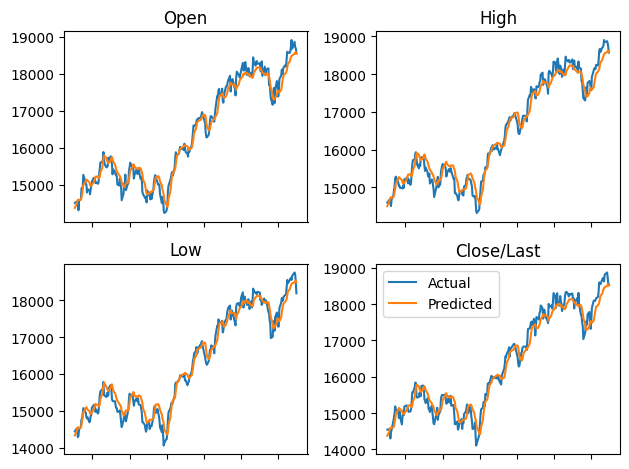

In [117]:
fig, ax = plt.subplots(2, 2)

ax[0,0].plot(df['Date'][train_size+seq_len:], df['Open'][train_size+seq_len:], label="Actual")
ax[0,0].plot(df['Date'][train_size+seq_len:], predicted_prices[:,0], label = "Predicted")
ax[0,0].set_title("Open")
ax[0,0].set_xticklabels([])

ax[0,1].plot(df['Date'][train_size+seq_len:], df['High'][train_size+seq_len:], label="Actual")
ax[0,1].plot(df['Date'][train_size+seq_len:], predicted_prices[:,1], label = "Predicted")
ax[0,1].set_title("High")
ax[0,1].set_xticklabels([])

ax[1,0].plot(df['Date'][train_size+seq_len:], df['Low'][train_size+seq_len:], label="Actual")
ax[1,0].plot(df['Date'][train_size+seq_len:], predicted_prices[:,2], label = "Predicted")
ax[1,0].set_title("Low")
ax[1,0].set_xticklabels([])

ax[1,1].plot(df['Date'][train_size+seq_len:], df['Close/Last'][train_size+seq_len:], label="Actual")
ax[1,1].plot(df['Date'][train_size+seq_len:], predicted_prices[:,3], label = "Predicted")
ax[1,1].set_title("Close/Last")
ax[1,1].set_xticklabels([])

plt.legend()
plt.tight_layout()
#save figure in plots folder
plt.savefig("plots/Attention_LSTM_NASDAQ100_5years.png")
plt.show()